In [411]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stat

In [412]:
df = pd.read_csv('bank.csv')
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,733,no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,29,no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0,no,yes,cellular,8,may,9,2,172,5,failure,no


In [413]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


### Data Preprocessing

In [414]:
bin = [10,20,30,40,50,60,70,80,100]
label = ['10대', '20대', '30대', '40대', '50대', '60대', '70대', '80대 이상']

df['AgeGroup'] = pd.cut(df['age'], bins=bin, labels=label,right=False)
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,AgeGroup
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,50대
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,50대
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,40대
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,50대
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes,50대
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1,yes,no,cellular,20,apr,257,1,-1,0,unknown,no,30대
11158,39,services,married,secondary,no,733,no,no,unknown,16,jun,83,4,-1,0,unknown,no,30대
11159,32,technician,single,secondary,no,29,no,no,cellular,19,aug,156,2,-1,0,unknown,no,30대
11160,43,technician,married,secondary,no,0,no,yes,cellular,8,may,9,2,172,5,failure,no,40대


In [415]:
df.drop(['age'], axis=1, inplace=True)

In [416]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   job        11162 non-null  object  
 1   marital    11162 non-null  object  
 2   education  11162 non-null  object  
 3   default    11162 non-null  object  
 4   balance    11162 non-null  int64   
 5   housing    11162 non-null  object  
 6   loan       11162 non-null  object  
 7   contact    11162 non-null  object  
 8   day        11162 non-null  int64   
 9   month      11162 non-null  object  
 10  duration   11162 non-null  int64   
 11  campaign   11162 non-null  int64   
 12  pdays      11162 non-null  int64   
 13  previous   11162 non-null  int64   
 14  poutcome   11162 non-null  object  
 15  deposit    11162 non-null  object  
 16  AgeGroup   11162 non-null  category
dtypes: category(1), int64(6), object(10)
memory usage: 1.4+ MB


### one-hot encoding + random forest model

In [417]:
categorical = [var for var in df.columns if df[var].dtype != 'int64']
print('categorical:',categorical)

numeric = [var for var in df.columns if df[var].dtype == 'int64']
print('numeric:',numeric)

categorical: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'deposit', 'AgeGroup']
numeric: ['balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


In [418]:
for var in categorical:
     print(df[var].value_counts()/np.float(len(df)))

management       0.229887
blue-collar      0.174162
technician       0.163322
admin.           0.119513
services         0.082691
retired          0.069701
self-employed    0.036284
student          0.032252
unemployed       0.031984
entrepreneur     0.029385
housemaid        0.024548
unknown          0.006271
Name: job, dtype: float64
married     0.568984
single      0.315176
divorced    0.115839
Name: marital, dtype: float64
secondary    0.490593
tertiary     0.330496
primary      0.134385
unknown      0.044526
Name: education, dtype: float64
no     0.984949
yes    0.015051
Name: default, dtype: float64
no     0.526877
yes    0.473123
Name: housing, dtype: float64
no     0.869199
yes    0.130801
Name: loan, dtype: float64
cellular     0.720480
unknown      0.210177
telephone    0.069342
Name: contact, dtype: float64
may    0.253001
aug    0.136087
jul    0.135639
jun    0.109479
nov    0.084483
apr    0.082691
feb    0.069522
oct    0.035119
jan    0.030819
sep    0.028579
mar    0.0

<ipython-input-418-31f3815c72d6>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  print(df[var].value_counts()/np.float(len(df)))


In [419]:
for var in categorical:
    print(var, 'contains', df[var].unique())

job contains ['admin.' 'technician' 'services' 'management' 'retired' 'blue-collar'
 'unemployed' 'entrepreneur' 'housemaid' 'unknown' 'self-employed'
 'student']
marital contains ['married' 'single' 'divorced']
education contains ['secondary' 'tertiary' 'primary' 'unknown']
default contains ['no' 'yes']
housing contains ['yes' 'no']
loan contains ['no' 'yes']
contact contains ['unknown' 'cellular' 'telephone']
month contains ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']
poutcome contains ['unknown' 'other' 'failure' 'success']
deposit contains ['yes' 'no']
AgeGroup contains ['50대', '40대', '60대', '30대', '20대', '70대', '80대 이상', '10대']
Categories (8, object): ['10대' < '20대' < '30대' < '40대' < '50대' < '60대' < '70대' < '80대 이상']


education, contact, poutcome 변수에 있는 unknown 값을 NaN으로 대체 한 후 각 데이터의 최빈값으로 대체

In [420]:
df['education'].replace('unknown', np.NAN, inplace=True)
df['contact'].replace('unknown', np.NAN, inplace=True)
df['poutcome'].replace('unknown', np.nan, inplace=True)

In [421]:
df.isnull().sum()

job             0
marital         0
education     497
default         0
balance         0
housing         0
loan            0
contact      2346
day             0
month           0
duration        0
campaign        0
pdays           0
previous        0
poutcome     8326
deposit         0
AgeGroup        0
dtype: int64

In [422]:
for var in categorical:
    df[var].fillna(df[var].mode()[0], inplace=True)

df

,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,AgeGroup
0,admin.,married,secondary,no,2343,yes,no,cellular,5,may,1042,1,-1,0,failure,yes,50대
1,admin.,married,secondary,no,45,no,no,cellular,5,may,1467,1,-1,0,failure,yes,50대
2,technician,married,secondary,no,1270,yes,no,cellular,5,may,1389,1,-1,0,failure,yes,40대
3,services,married,secondary,no,2476,yes,no,cellular,5,may,579,1,-1,0,failure,yes,50대
4,admin.,married,tertiary,no,184,no,no,cellular,5,may,673,2,-1,0,failure,yes,50대
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,blue-collar,single,primary,no,1,yes,no,cellular,20,apr,257,1,-1,0,failure,no,30대
11158,services,married,secondary,no,733,no,no,cellular,16,jun,83,4,-1,0,failure,no,30대
11159,technician,single,secondary,no,29,no,no,cellular,19,aug,156,2,-1,0,failure,no,30대
11160,technician,married,secondary,no,0,no,yes,cellular,8,may,9,2,172,5,failure,no,40대


In [423]:
df.isnull().sum()

job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
AgeGroup     0
dtype: int64

In [424]:
# deposit는 목표변수 이므로 train 데이터에서 쓰이지 않으므로 미리 categorical에서 제거해줌

categorical.remove('deposit')

In [425]:
from sklearn.model_selection import train_test_split

X = df.drop(['deposit'], axis=1)
y = df['deposit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [426]:
# 정확도를 높이기 위해 범주형 변수들을 원-핫 인코딩처리

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

categorical_column = categorical
encoder = OneHotEncoder(drop='first', sparse=False)

X_train_encoded = encoder.fit_transform(X_train[categorical_column])
X_test_encoded = encoder.fit_transform(X_test[categorical_column])

X_train_encoded_rf = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names(categorical_column), index=X_train.index)
X_test_encoded_rf = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names(categorical_column), index=X_test.index)

In [427]:
X_train_encoded_rf

,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,...,month_sep,poutcome_other,poutcome_success,AgeGroup_20대,AgeGroup_30대,AgeGroup_40대,AgeGroup_50대,AgeGroup_60대,AgeGroup_70대,AgeGroup_80대 이상
6111,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1149,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2954,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2458,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4859,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3264,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9845,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
10799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [428]:
X_test_encoded_rf

,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,...,month_sep,poutcome_other,poutcome_success,AgeGroup_20대,AgeGroup_30대,AgeGroup_40대,AgeGroup_50대,AgeGroup_60대,AgeGroup_70대,AgeGroup_80대 이상
9058,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3279,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6502,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9327,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9965,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5606,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4808,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3697,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [429]:
X_train_new = pd.concat([X_train[numeric], X_train_encoded_rf], axis=1)

X_test_new = pd.concat([X_test[numeric], X_test_encoded_rf], axis=1)

In [430]:
X_train_new

,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,month_sep,poutcome_other,poutcome_success,AgeGroup_20대,AgeGroup_30대,AgeGroup_40대,AgeGroup_50대,AgeGroup_60대,AgeGroup_70대,AgeGroup_80대 이상
6111,104,8,285,1,-1,0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1149,514,3,261,1,-1,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2954,195,16,984,5,-1,0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2458,687,7,221,1,99,2,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7504,1077,18,432,3,374,3,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4859,2,3,322,1,-1,0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3264,5473,24,127,2,184,2,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9845,179,8,14,8,-1,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
10799,54,21,226,1,-1,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [431]:
# X_train_new에 있는 독립 변수들의 VIF 계산
def calculate_vif(data):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = data.columns
    vif_data["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_data

# 독립 변수만 선택
independent_vars = X_train_new

# VIF 계산
vif_result = calculate_vif(independent_vars)
vif_result

,Variable,VIF
0,balance,1.289302
1,day,5.513581
2,duration,2.184148
3,campaign,2.090271
4,pdays,1.935659
5,previous,1.683240
6,job_blue-collar,2.654356
7,job_entrepreneur,1.291953
8,job_housemaid,1.293281
9,job_management,3.886834


In [432]:
from sklearn.preprocessing import RobustScaler, StandardScaler

scaler = StandardScaler()
X_train_new[numeric] = scaler.fit_transform(X_train[numeric])
X_test_new[numeric] = scaler.transform(X_test[numeric])


# 스케일러 적용 후 
X_train_new

,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,month_sep,poutcome_other,poutcome_success,AgeGroup_20대,AgeGroup_30대,AgeGroup_40대,AgeGroup_50대,AgeGroup_60대,AgeGroup_70대,AgeGroup_80대 이상
6111,-0.445653,-0.905048,-0.248355,-0.563948,-0.484285,-0.358883,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1149,-0.316172,-1.500039,-0.317591,-0.563948,-0.484285,-0.358883,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2954,-0.416914,0.046938,1.768162,0.928271,-0.484285,-0.358883,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2458,-0.261538,-1.024046,-0.432986,-0.563948,0.435677,0.486845,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7504,-0.138373,0.284935,0.175720,0.182161,2.965573,0.909709,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4859,-0.477865,-1.500039,-0.141615,-0.563948,-0.484285,-0.358883,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3264,1.249911,0.998925,-0.704162,-0.190893,1.217645,0.486845,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9845,-0.421967,-0.905048,-1.030151,2.047435,-0.484285,-0.358883,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
10799,-0.461443,0.641930,-0.418561,-0.563948,-0.484285,-0.358883,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [433]:
# 스케일러를 통해 연속형 변수에 해당하는 독립 변수들을 스케일링 한 후 VIF 계산
def calculate_vif(data):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = data.columns
    vif_data["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_data

# 독립 변수만 선택
independent_vars = X_train_new

# VIF 계산
vif_result = calculate_vif(independent_vars)
vif_result

,Variable,VIF
0,balance,1.048607
1,day,1.247425
2,duration,1.019307
3,campaign,1.112699
4,pdays,1.579912
5,previous,1.490455
6,job_blue-collar,2.653324
7,job_entrepreneur,1.291777
8,job_housemaid,1.292969
9,job_management,3.884629


In [434]:
# 다중공선성이 높은 AgeGroup_30대 변수를 제거

X_train_new = X_train_new.drop(['AgeGroup_30대'], axis=1)

In [435]:
X_train_new

,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,month_oct,month_sep,poutcome_other,poutcome_success,AgeGroup_20대,AgeGroup_40대,AgeGroup_50대,AgeGroup_60대,AgeGroup_70대,AgeGroup_80대 이상
6111,-0.445653,-0.905048,-0.248355,-0.563948,-0.484285,-0.358883,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1149,-0.316172,-1.500039,-0.317591,-0.563948,-0.484285,-0.358883,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2954,-0.416914,0.046938,1.768162,0.928271,-0.484285,-0.358883,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2458,-0.261538,-1.024046,-0.432986,-0.563948,0.435677,0.486845,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
7504,-0.138373,0.284935,0.175720,0.182161,2.965573,0.909709,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4859,-0.477865,-1.500039,-0.141615,-0.563948,-0.484285,-0.358883,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3264,1.249911,0.998925,-0.704162,-0.190893,1.217645,0.486845,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
9845,-0.421967,-0.905048,-1.030151,2.047435,-0.484285,-0.358883,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10799,-0.461443,0.641930,-0.418561,-0.563948,-0.484285,-0.358883,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [436]:
X_test_new = X_test_new.drop(['AgeGroup_30대'], axis=1)

In [437]:
X_test_new

,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,month_oct,month_sep,poutcome_other,poutcome_success,AgeGroup_20대,AgeGroup_40대,AgeGroup_50대,AgeGroup_60대,AgeGroup_70대,AgeGroup_80대 이상
9058,-0.450706,-0.548053,-0.767629,-0.563948,2.615988,0.486845,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3279,0.133536,1.236921,-0.409907,-0.563948,1.291242,1.332573,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
6502,-0.401124,-0.905048,-0.531071,-0.190893,-0.484285,-0.358883,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9327,-0.037631,0.165937,0.746922,-0.563948,-0.484285,-0.358883,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9965,-0.482602,-0.191058,0.406508,0.182161,-0.484285,-0.358883,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6003,-0.475970,-0.310057,-0.314706,-0.190893,-0.484285,-0.358883,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5606,-0.473760,-0.786050,-0.329131,-0.563948,-0.484285,-0.358883,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4808,0.558927,0.641930,3.415416,-0.190893,-0.484285,-0.358883,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3697,-0.271959,-0.667051,-0.877254,-0.563948,-0.484285,-0.358883,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [524]:
# 랜덤포레스트 모델

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_new, y_train)

y_pred = rf.predict(X_test_new)

accuracy_score_rf = accuracy_score(y_test, y_pred)
accuracy_score_rf

0.8356471115091805

In [529]:
# 로지스틱 분류 모델

from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(random_state=42)
log_model.fit(X_train_new, y_train)

y_pred_log = log_model.predict(X_test_new)
accuracy_score_log = accuracy_score(y_test, y_pred_log)
accuracy_score_log

0.8154948499776086

In [532]:
# 서포트 벡터 머신 모델

from sklearn.svm import SVC

svm_model = SVC(random_state=42)
svm_model.fit(X_train_new, y_train)

y_pred_svm = svm_model.predict(X_test_new)

accuracy_score_svm = accuracy_score(y_test, y_pred_svm)
accuracy_score_svm

0.8414688759516346

In [535]:
# XGboost 모델

from xgboost import XGBClassifier

y_train_xg = y_train.replace({'yes' : 1, 'no' : 0})
y_test_xg =  y_test.replace({'yes' : 1, 'no' : 0})

xg_model = XGBClassifier(random_state=42)
xg_model.fit(X_train_new, y_train_xg) 

y_pred_xg = xg_model.predict(X_test_new)
accuracy_score_xg = accuracy_score(y_test_xg, y_pred_xg)
accuracy_score_xg


0.8459471562919839

In [537]:
print("Randomforest model test accuracy:", accuracy_score_rf)
print("LogisticClassification model test accuracy:", accuracy_score_log)
print("SVM model test accuracy:", accuracy_score_svm)
print("XBboost model test accuracy:", accuracy_score_xg)

Randomforest model test accuracy: 0.8356471115091805
LogisticClassification model test accuracy: 0.8154948499776086
SVM model test accuracy: 0.8414688759516346
XBboost model test accuracy: 0.8459471562919839


Feature Selection 

In [442]:
from sklearn.metrics import confusion_matrix,classification_report,plot_confusion_matrix
confusion_matrix=confusion_matrix(y_test,y_pred)
confusion_matrix

array([[988, 217],
       [148, 880]], dtype=int64)

In [443]:
print(np.round(rf.feature_importances_, 3))

[0.094 0.08  0.348 0.043 0.045 0.029 0.01  0.004 0.003 0.01  0.006 0.005
 0.007 0.005 0.01  0.004 0.001 0.012 0.01  0.012 0.011 0.002 0.032 0.012
 0.007 0.011 0.002 0.01  0.006 0.011 0.01  0.014 0.019 0.009 0.013 0.006
 0.004 0.038 0.011 0.012 0.01  0.008 0.004 0.001]


In [444]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train_new.columns)
feat_importances

balance                0.094404
day                    0.080287
duration               0.347508
campaign               0.042987
pdays                  0.044806
previous               0.029437
job_blue-collar        0.010326
job_entrepreneur       0.003586
job_housemaid          0.003195
job_management         0.009709
job_retired            0.006304
job_self-employed      0.004523
job_services           0.006671
job_student            0.005012
job_technician         0.010273
job_unemployed         0.004352
job_unknown            0.001369
marital_married        0.012371
marital_single         0.010080
education_secondary    0.011885
education_tertiary     0.011192
default_yes            0.001844
housing_yes            0.032329
loan_yes               0.012013
contact_telephone      0.006816
month_aug              0.011003
month_dec              0.002092
month_feb              0.009565
month_jan              0.005682
month_jul              0.010897
month_jun              0.009523
month_ma

In [445]:
feat_importances = feat_importances.sort_values(ascending=False)
feat_importances

duration               0.347508
balance                0.094404
day                    0.080287
pdays                  0.044806
campaign               0.042987
poutcome_success       0.038046
housing_yes            0.032329
previous               0.029437
month_may              0.018706
month_mar              0.013618
month_oct              0.012550
marital_married        0.012371
loan_yes               0.012013
education_secondary    0.011885
AgeGroup_40대           0.011791
AgeGroup_20대           0.011262
education_tertiary     0.011192
month_aug              0.011003
month_jul              0.010897
job_blue-collar        0.010326
job_technician         0.010273
marital_single         0.010080
job_management         0.009709
month_feb              0.009565
AgeGroup_50대           0.009539
month_jun              0.009523
month_nov              0.009042
AgeGroup_60대           0.007868
contact_telephone      0.006816
job_services           0.006671
month_sep              0.006459
job_reti

c:\Users\pc\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 45824 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\pc\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 45824 missing from current font.
  font.set_text(s, 0, flags=flags)


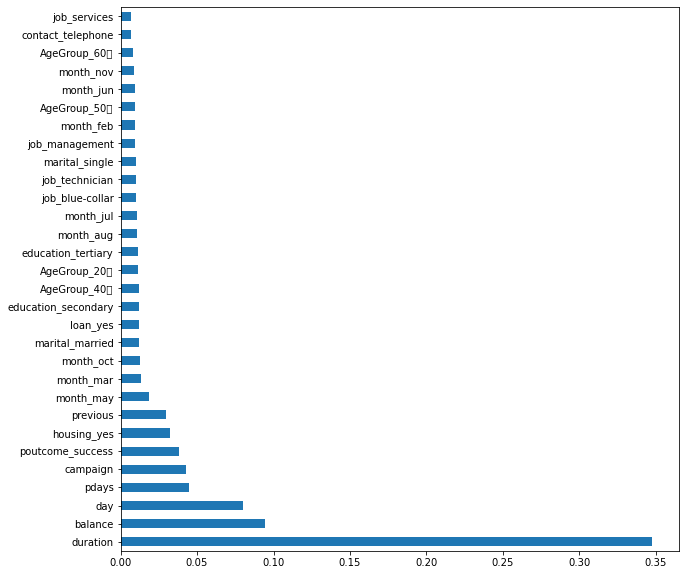

In [446]:
plt.figure(figsize=(10,10))
feat_importances.nlargest(30).plot(kind='barh')
plt.show()

In [447]:
top_10_feature = feat_importances[:10]
top_10_feature

duration            0.347508
balance             0.094404
day                 0.080287
pdays               0.044806
campaign            0.042987
poutcome_success    0.038046
housing_yes         0.032329
previous            0.029437
month_may           0.018706
month_mar           0.013618
dtype: float64

In [448]:
X_train_new2 = X_train_new[['duration','balance' ,'day','pdays','campaign','poutcome_success'           
,'housing_yes','previous','month_may','month_mar']]

X_test_new2 = X_test_new[['duration','balance' ,'day','pdays','campaign','poutcome_success'           
,'housing_yes','previous','month_may','month_mar']]

X_train_new2

,duration,balance,day,pdays,campaign,poutcome_success,housing_yes,previous,month_may,month_mar
6111,-0.248355,-0.445653,-0.905048,-0.484285,-0.563948,0.0,1.0,-0.358883,1.0,0.0
1149,-0.317591,-0.316172,-1.500039,-0.484285,-0.563948,0.0,0.0,-0.358883,0.0,0.0
2954,1.768162,-0.416914,0.046938,-0.484285,0.928271,0.0,0.0,-0.358883,0.0,0.0
2458,-0.432986,-0.261538,-1.024046,0.435677,-0.563948,1.0,1.0,0.486845,0.0,0.0
7504,0.175720,-0.138373,0.284935,2.965573,0.182161,0.0,1.0,0.909709,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
4859,-0.141615,-0.477865,-1.500039,-0.484285,-0.563948,0.0,0.0,-0.358883,0.0,0.0
3264,-0.704162,1.249911,0.998925,1.217645,-0.190893,1.0,0.0,0.486845,0.0,0.0
9845,-1.030151,-0.421967,-0.905048,-0.484285,2.047435,0.0,0.0,-0.358883,0.0,0.0
10799,-0.418561,-0.461443,0.641930,-0.484285,-0.563948,0.0,1.0,-0.358883,0.0,0.0


In [477]:
rf.fit(X_train_new2, y_train)

y_pred2 = rf.predict(X_test_new2)

print(accuracy_score(y_test, y_pred2))

0.8038513210927004


In [450]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
# Build EXC classifier to use in feature selection

clf = RandomForestClassifier(n_estimators=60,random_state=42)

# Build step forward feature selection
sfs1 = sfs(clf,
           k_features=8,
           forward=True,
           floating=False,
           verbose=2,
           scoring='accuracy',
           cv=9)

# Perform SFFS
sfs1 = sfs1.fit(X_train_new2, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.2s finished

[2024-01-18 00:14:50] Features: 1/8 -- score: 0.6731989518024017[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   28.4s finished

[2024-01-18 00:15:18] Features: 2/8 -- score: 0.7363658061628533[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   26.2s finished

[2024-01-18 00:15:44] Features: 3/8 -- score: 0.751483164408927[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 o

In [453]:
features_cols = list(sfs1.k_feature_names_)
print(features_cols)

['duration', 'balance', 'day', 'pdays', 'campaign', 'housing_yes', 'month_may', 'month_mar']


In [457]:
X_train_new3 = X_train_new2[['duration', 'balance', 'day', 'pdays', 'campaign', 'housing_yes', 'month_may', 'month_mar']]
X_test_new3 = X_test_new2[['duration', 'balance', 'day', 'pdays', 'campaign', 'housing_yes', 'month_may', 'month_mar']]

In [458]:
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train_new3, y_train)

y_pred = clf.predict(X_test_new3)

print('Test accuracy score with 10 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
pd.DataFrame(y_pred)

Test accuracy score with 10 decision-trees : 0.8003


,0
0,no
1,yes
2,no
3,yes
4,yes
...,...
2228,no
2229,no
2230,yes
2231,no
